In [1]:
import random
random.seed(42)

In [2]:
import numpy as np 
import pandas as pd 
 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import  confusion_matrix, f1_score, make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt 

df = pd.read_csv('journeys.csv') 
targets = df['Conversion'] 
df.drop(['Journey Start Date', 'Journey End Date', 'Events Combo', 'User-Journey'], axis=1, inplace=True) 
df = pd.get_dummies(df) 
 
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.3) 
X_train.drop(['Conversion'], axis=1, inplace=True) 
X_test.drop(['Conversion'], axis=1, inplace=True) 

scaler = StandardScaler() 
scaler.fit(X_train) 
 
s_X_train = scaler.transform(X_train) 
s_X_test = scaler.transform(X_test) 

X_train = pd.DataFrame(s_X_train, columns = X_train.columns)
X_test = pd.DataFrame(s_X_test, columns = X_test.columns)

ModuleNotFoundError: No module named 'numpy'

In [3]:
os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=os_data_X, columns=columns)
y_train = pd.DataFrame(data=os_data_y, columns=['Conversion'])

In [3]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

NameError: name 'y_train' is not defined

In [5]:
param_grid = { 
    'min_samples_split': [3, 5, 10],  
    'n_estimators' : [300], 
    'max_depth': [3, 5, 15, 25], 
    'max_features': [3, 5, 10, 19]

} 
  
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  
def grid_search_wrapper(_model = '', param_grid=param_grid): 
    grid_search = GridSearchCV(_model, param_grid, scoring=make_scorer(f1_score),
        return_train_score=True, n_jobs=-1, error_score='raise', cv=10) 
    grid_search.fit(X_train, y_train) 
 
    # make the predictions 
    y_pred = grid_search.predict(X_test) 
 
    print('Best params for {}'.format('f1')) 
    print(grid_search.best_params_) 
 
    # confusion matrix on the test data. 
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('f1')) 
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    return grid_search

def show_model_output(grid_search_output, num_to_show = 10): 
    try:
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df2 = pd.DataFrame(grid_search_output.cv_results_['mean_train_score']).rename(columns={0: "mean_train_score"})
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_out_of_sample_estimate_score"})
        result = pd.concat([df2,df3,df1], axis = 1).sort_values(by='mean_out_of_sample_estimate_score', ascending=False)
        result = result.head(num_to_show)
    except Exception:
    ## for some reason logistic regression doesnt have mean_train_score
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_out_of_sample_estimate_score"})
        result = pd.concat([df3,df1], axis = 1).sort_values(by='mean_out_of_sample_estimate_score', ascending=False)
        result = result.head(num_to_show)
    return result



In [ ]:
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [12]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [13]:
grid_search_xgb = grid_search_wrapper(_model = xgb, param_grid=param_grid) 

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "penalty", "silent", "solver" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params for f1
{'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1870        63
pos       111       194


In [14]:
show_model_output(grid_search_output= grid_search_xgb, num_to_show=10)

,mean_train_score,mean_out_of_sample_estimate_score,C,penalty,solver
0,0.857132,0.846807,0.001,l1,newton-cg
31,0.857132,0.846807,100.000,l1,lbfgs
23,0.857132,0.846807,1.000,l2,liblinear
24,0.857132,0.846807,10.000,l1,newton-cg
25,0.857132,0.846807,10.000,l1,lbfgs
26,0.857132,0.846807,10.000,l1,liblinear
27,0.857132,0.846807,10.000,l2,newton-cg
28,0.857132,0.846807,10.000,l2,lbfgs
29,0.857132,0.846807,10.000,l2,liblinear
30,0.857132,0.846807,100.000,l1,newton-cg


### SHAP

##### XGBooost

In [46]:
model3 = grid_search_xgb.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model3, X_train)
shap_values = explainer.shap_values(X_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "penalty", "silent", "solver" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 99%|===================| 8909/8972 [01:16<00:00]        

In [47]:
y_pred = model3.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1933
           1       0.75      0.64      0.69       305

    accuracy                           0.92      2238
   macro avg       0.85      0.80      0.82      2238
weighted avg       0.92      0.92      0.92      2238



In [48]:
FP = X_test[(y_test == 0) & (y_pred == 1)]

In [52]:
FP

,Journey Number,# of Touchpoints,Journey Duration,Email,Facebook,House Ads,Instagram,Push,age_group_0-18 years,age_group_19-24 years,age_group_24-30 years,age_group_30-36 years,age_group_36-45 years,age_group_45-55 years,age_group_55+ years,language_preferred_Arabic,language_preferred_English,language_preferred_German,language_preferred_Spanish
22,-0.155329,1.820328,-0.014935,3.973384,-0.529715,0.957795,-0.540081,-0.379081,-0.431649,-0.460971,2.338726,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
38,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,2.316694,-0.460971,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
53,-0.155329,1.820328,-0.014935,-0.251675,-0.529715,0.957795,1.851575,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
105,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
127,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,-0.155329,-0.325514,-0.400001,-0.251675,-0.529715,0.957795,-0.540081,-0.379081,-0.431649,-0.460971,-0.427583,-0.392189,-0.385989,2.673029,-0.382049,-0.120725,-3.669142,7.965977,-0.202161
2134,-0.155329,1.820328,-0.207468,-0.251675,-0.529715,0.957795,1.851575,-0.379081,-0.431649,-0.460971,2.338726,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
2155,-0.155329,1.820328,0.370131,-0.251675,-0.529715,0.957795,1.851575,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
2166,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,-0.431649,-0.460971,2.338726,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161


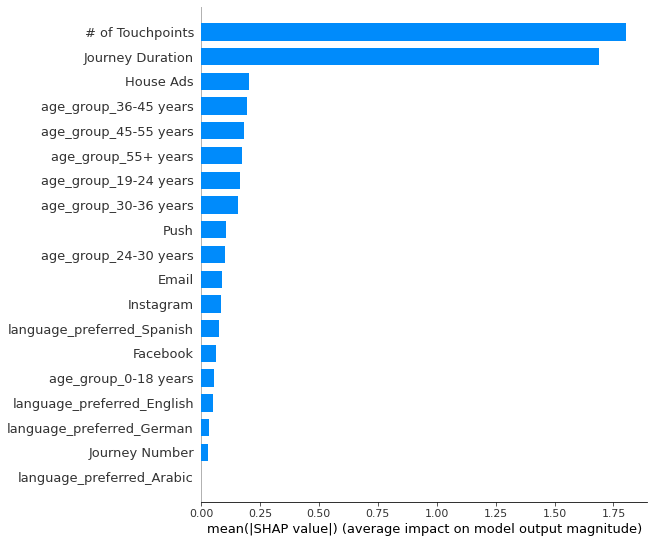

In [28]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

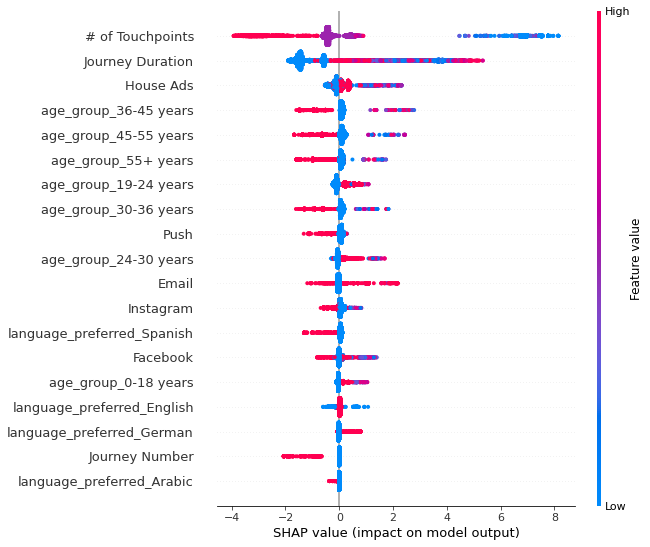

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model3.classes_)